In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import torch
import torch.nn as nn
from datasets import load_dataset

from transformers import BertTokenizer, BertForQuestionAnswering, BertConfig

from captum.attr import visualization as viz
from captum.attr import LayerConductance, LayerIntegratedGradients

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# replace <PATd:/spofrte/modeH-TO-SAVED-MODEL> with the real path of the saved model
model_path = 'bert-large-uncased-whole-word-masking-finetuned-squad'

# load model
model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
model.to(device)
model.eval()
model.zero_grad()


"""++++++++++++++++++这几个函数是计算f1 score 数值的，代码是抄的，千万不能改！+++++++++++++++++"""


def normalize_text(s):
    """Removing articles and punctuation, and standardizing whitespace are all typical text processing steps."""
    import string, re

    def remove_articles(text):
        regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
        return re.sub(regex, " ", text)

    def white_space_fix(text):
        return " ".join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return "".join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))


def compute_exact_match(prediction, truth):
    return int(normalize_text(prediction) == normalize_text(truth))


def compute_f1(prediction, truth):
    pred_tokens = normalize_text(prediction).split()
    truth_tokens = normalize_text(truth).split()

    # if either the prediction or the truth is no-answer then f1 = 1 if they agree, 0 otherwise
    if len(pred_tokens) == 0 or len(truth_tokens) == 0:
        return int(pred_tokens == truth_tokens)

    common_tokens = set(pred_tokens) & set(truth_tokens)

    # if there are no common tokens then f1 = 0
    if len(common_tokens) == 0:
        return 0

    prec = len(common_tokens) / len(pred_tokens)
    rec = len(common_tokens) / len(truth_tokens)

    return 2 * (prec * rec) / (prec + rec)

# load tokenizer
tokenizer = BertTokenizer.from_pretrained(model_path)


def predict(inputs, token_type_ids=None, position_ids=None, attention_mask=None):
    output = model(inputs, token_type_ids=token_type_ids,
                   position_ids=position_ids, attention_mask=attention_mask, )
    return output.start_logits, output.end_logits


def squad_pos_forward_func(inputs, token_type_ids=None, position_ids=None, attention_mask=None, position=0):
    pred = predict(inputs,
                   token_type_ids=token_type_ids,
                   position_ids=position_ids,
                   attention_mask=attention_mask)
    pred = pred[position]
    return pred.max(1).values

fig = plt.figure()  
fig.set_size_inches(8, 6)

ref_token_id = tokenizer.pad_token_id  # A token used for generating token reference
sep_token_id = tokenizer.sep_token_id  # A token used as a separator between question and text and it is also added to the end of the text.
cls_token_id = tokenizer.cls_token_id  # A token used for prepending to the concatenated question-text word sequence


def summarize_attributions(attributions):
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    return attributions


def construct_input_ref_pair(question, text, ref_token_id, sep_token_id, cls_token_id):
    question_ids = tokenizer.encode(question, add_special_tokens=False)
    text_ids = tokenizer.encode(text, add_special_tokens=False)

    # construct input token ids
    input_ids = [cls_token_id] + question_ids + [sep_token_id] + text_ids + [sep_token_id]

    # construct reference token ids
    ref_input_ids = [cls_token_id] + [ref_token_id] * len(question_ids) + [sep_token_id] + \
                    [ref_token_id] * len(text_ids) + [sep_token_id]

    return torch.tensor([input_ids], device=device), torch.tensor([ref_input_ids], device=device), len(question_ids)


def construct_input_ref_token_type_pair(input_ids, sep_ind=0):
    seq_len = input_ids.size(1)
    token_type_ids = torch.tensor([[0 if i <= sep_ind else 1 for i in range(seq_len)]], device=device)
    ref_token_type_ids = torch.zeros_like(token_type_ids, device=device)  # * -1
    return token_type_ids, ref_token_type_ids


def construct_input_ref_pos_id_pair(input_ids):
    seq_length = input_ids.size(1)
    position_ids = torch.arange(seq_length, dtype=torch.long, device=device)
    # we could potentially also use random permutation with `torch.randperm(seq_length, device=device)`
    ref_position_ids = torch.zeros(seq_length, dtype=torch.long, device=device)

    position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
    ref_position_ids = ref_position_ids.unsqueeze(0).expand_as(input_ids)
    return position_ids, ref_position_ids


def construct_attention_mask(input_ids):
    return torch.ones_like(input_ids)


def construct_whole_bert_embeddings(input_ids, ref_input_ids, \
                                    token_type_ids=None, ref_token_type_ids=None, \
                                    position_ids=None, ref_position_ids=None):
    input_embeddings = model.bert.embeddings(input_ids, token_type_ids=token_type_ids, position_ids=position_ids)
    ref_input_embeddings = model.bert.embeddings(ref_input_ids, token_type_ids=token_type_ids,
                                                 position_ids=position_ids)

    return input_embeddings, ref_input_embeddings


def predict_qt(question, text):
    input_ids, ref_input_ids, sep_id = construct_input_ref_pair(question, text, ref_token_id, sep_token_id,
                                                                cls_token_id)
    token_type_ids, ref_token_type_ids = construct_input_ref_token_type_pair(input_ids, sep_id)
    position_ids, ref_position_ids = construct_input_ref_pos_id_pair(input_ids)
    attention_mask = construct_attention_mask(input_ids)

    indices = input_ids[0].detach().tolist()
    all_tokens = tokenizer.convert_ids_to_tokens(indices)

    ground_truth = '13'

    start_scores, end_scores = predict(input_ids, \
                                       token_type_ids=token_type_ids, \
                                       position_ids=position_ids, \
                                       attention_mask=attention_mask)

    print('Question: ', question)
    print('Predicted Answer: ', ' '.join(all_tokens[torch.argmax(start_scores): torch.argmax(end_scores) + 1]))
    return input_ids, ref_input_ids, token_type_ids, position_ids, attention_mask, start_scores, end_scores, ground_truth, all_tokens,


def explain(input_ids, ref_input_ids, token_type_ids, position_ids, attention_mask, start_scores, end_scores,
            ground_truth, all_tokens, ):
    lig = LayerIntegratedGradients(squad_pos_forward_func, model.bert.embeddings)

    attributions_start, delta_start = lig.attribute(inputs=input_ids,
                                                    baselines=ref_input_ids,
                                                    additional_forward_args=(
                                                        token_type_ids, position_ids, attention_mask, 0),
                                                    internal_batch_size=4,
                                                    return_convergence_delta=True)
    attributions_end, delta_end = lig.attribute(inputs=input_ids, baselines=ref_input_ids,
                                                additional_forward_args=(
                                                    token_type_ids, position_ids, attention_mask, 1),
                                                internal_batch_size=4,
                                                return_convergence_delta=True)

    attributions_start_sum = summarize_attributions(attributions_start)
    attributions_end_sum = summarize_attributions(attributions_end)
    # storing couple samples in an array for visualization purposes
    start_position_vis = viz.VisualizationDataRecord(
        attributions_start_sum,
        torch.max(torch.softmax(start_scores[0], dim=0)),
        torch.argmax(start_scores),
        torch.argmax(start_scores),
        str(ground_truth),
        attributions_start_sum.sum(),
        all_tokens,
        delta_start)

    end_position_vis = viz.VisualizationDataRecord(
        attributions_end_sum,
        torch.max(torch.softmax(end_scores[0], dim=0)),
        torch.argmax(end_scores),
        torch.argmax(end_scores),
        str(ground_truth),
        attributions_end_sum.sum(),
        all_tokens,
        delta_end)
    #print(all_tokens)
    print('\033[1m', 'Visualizations For Start Position', '\033[0m')
    viz.visualize_text([start_position_vis])

    print('\033[1m', 'Visualizations For End Position', '\033[0m')

    print("attributions_start_sum:   ", len(attributions_start_sum))
    #print("all tokens:    ", len(all_tokens))

    return all_tokens, attributions_start_sum


def get_posneg(all_tokens, attributions_start_sum):
    positive = []
    negative = []
    neutral = []
    for i, j in enumerate(attributions_start_sum):
        if j > 0:
            positive.append(i)
            # print('positive:',j)
        ##print(all_tokens[i])
        elif j < 0:
            negative.append(i)
            # print('negative:',j)
            # print(all_tokens[i])
        elif j == 0:
            neutral.append(i)

    s_pos = ''
    s_neg = ''

    # print(len(attributions_start_sum))
    # print(len(positive))
    # print(len(negative))

    for i in positive:
        s_pos += all_tokens[i] + ' '
    #print("positive :", s_pos)
    for i in negative:
        s_neg += all_tokens[i] + ' '
    #print("negative :", s_neg)
    return positive, negative, neutral


def separate_sentence(all_tokens):
    sentence = {}
    temp = []
    num = 0
    for i in range(len(all_tokens)):
        if all_tokens[i] == "," or all_tokens[i] == ".":
            temp.append(all_tokens[i])
            sentence[num] = temp
            temp = []
            num = num + 1
        elif all_tokens[i] == "[CLS]":
            temp.append(all_tokens[i])
            sentence[num] = temp
            temp = []
            num = num + 1
        elif all_tokens[i] == "[SEP]":
            sentence[num] = temp
            num = num + 1
            temp = [all_tokens[i]]
            sentence[num] = temp
            temp = []
            num = num + 1
        else:
            temp.append(all_tokens[i])
    return sentence
def get_sence_score(sentence, attributions_start_sum):
    weight = 0
    sum_weight = 0
    sentence_value=[]
    delete_sentence = []
    for k,v in sentence.items():
        for i in v:
            sentence_value.append(i)
    scores={}


    for i in range(len(attributions_start_sum)):
        try:
            scores[sentence_value[i]]=attributions_start_sum[i].item()
        except:
            pass


    for i, j in sentence.items():
        sum_weight = 0
        for word in j:
            sum_weight +=  scores[word]
        delete_sentence.append(sum_weight)
        #print(sum_weight)
    return delete_sentence

def get_delete(sentence):
    weight = 0
    sum_weight = 0
    sentence_value = []
    delete_sentence = {}
    for k, v in sentence.items():
        # print(k,':',v)
        for i in v:
            sentence_value.append(i)
    #print(sentence_value)
    scores = {}
    # print(attributions_start_sum[0].item())

    for i in range(len(attributions_start_sum)):
        try:
            scores[sentence_value[i]] = attributions_start_sum[i].item()
        except:
            pass

    for i, j in sentence.items():
        sum_weight = 0
        for word in j:
            weight = 0

            sum_weight += scores[word]
            delete_sentence[i] = sum_weight
    return delete_sentence


def delete_sentence(sentence, li_delete_sentence):
    for i, j in sentence.items():
        if i in li_delete_sentence:
            sentence[i] = []
        else:
            pass
    return sentence


def rebuild_sentence(ori_sentence):
    rebuild_str = ""
    for i, j in ori_sentence.items():
        for word in j:
            rebuild_str += word
            rebuild_str += " "
    return rebuild_str


def pred_explain(question, text):
    input_ids, ref_input_ids, token_type_ids, position_ids, attention_mask, start_scores, end_scores, ground_truth, all_tokens, = predict_qt(
        text, question)

    all_tokens, attributions_start_sum = explain(input_ids, ref_input_ids, token_type_ids, position_ids, attention_mask,
                                                 start_scores, end_scores, ground_truth, all_tokens, )

    end_score = float(torch.max(torch.softmax(end_scores[0], dim=0)))
    start_score = float(torch.max(torch.softmax(start_scores[0], dim=0)))
    return all_tokens, attributions_start_sum, end_score, start_score, [torch.argmax(start_scores), torch.argmax(end_scores)+1], start_scores, end_scores
def max_min(x, y, z):
    max = min = x
    i = 1
    if y > max:
        max = y
        i = 2
    else:
        min = y
    if z > max:
        max = z
        i =3
    else:
        min = z
    return (i)
def cycle_prediction(cycle_num, question, text, s_answer):
    all_tokens, attributions_start_sum, start_acc, end_acc, an_index, start_scores, end_scores = pred_explain(text,
                                                                                                              question)

    f1 = []
    acc_s = []
    acc_e = []
    sun = []
    ans = []
    second_answer = ' '.join(all_tokens[torch.argmax(start_scores): torch.argmax(end_scores) + 1])
    second_answer = re.sub(r' ##', '', second_answer)
    f1_score = compute_f1(second_answer, s_answer)
    f1.append(f1_score)
    for loop in range(cycle_num):
        sentence = separate_sentence(all_tokens)
        sentence_score = get_sence_score(sentence, attributions_start_sum)
        min_sensocer = 999
        min_index = 999
        for i in range(len(sentence_score)):
            if sentence_score[i] < min_sensocer and sentence_score[i] != 0:
                min_sensocer = sentence_score[i]
                min_index = i
        # print("should delete", min_index, min_sensocer)
        sentence[min_index] = ''
        sentence[1] = ''
        retext = ""
        for i, j in sentence.items():
            for words in j:
                retext = retext + words + " "
        li_sep = []
        for m in re.finditer(r"SEP", retext):
            li_sep.append(m.start())
            li_sep.append(m.end())
        retext = retext[li_sep[1] + 1: li_sep[2] - 1]
        retext = re.sub(r' ##', '', retext)

        all_tokens, attributions_start_sum, start_acc, end_acc, an_index, start_scores, end_scores = pred_explain(
            retext, question)
        reanswer = ' '.join(all_tokens[torch.argmax(start_scores): torch.argmax(end_scores) + 1])
        # print(start_acc, end_acc)
        second_answer = ' '.join(all_tokens[torch.argmax(start_scores): torch.argmax(end_scores) + 1])
        second_answer = re.sub(r' ##', '', second_answer)
        # print("my answer is ", second_answer)
        ans.append(second_answer)
        # print(start_acc, end_acc)
        acc_s.append(start_acc)
        acc_e.append(end_acc)
        pos_contri = 0
        neg_contri = 0
        f1_score = compute_f1(second_answer, s_answer)
        f1.append(f1_score)

        # print(acc_s, acc_e)
        # print(acc_s, acc_e)
   
    for i in range(len(acc_s)):
        sun.append((acc_s[i] + acc_e[i]) / 2)
    print("f1 : ", f1)
    print("possibility1 : ", acc_s)
    print("possibility2 : ", acc_e)
    print("possibility average : ", sun)
    return f1, acc_s, acc_e, sun, ans

<Figure size 576x432 with 0 Axes>

In [2]:
text = """The remaining band members recorded "Independent Women Part I", which appeared on the soundtrack to the 2000 film, Charlie's Angels. It became their best-charting single, topping the U.S. Billboard Hot 100 chart for eleven consecutive weeks. In early 2001, while Destiny's Child was completing their third album, Beyoncé landed a major role in the MTV made-for-television film, Carmen: A Hip Hopera, starring alongside American actor Mekhi Phifer. Set in Philadelphia, the film is a modern interpretation of the 19th century opera Carmen by French composer Georges Bizet. When the third album Survivor was released in May 2001, Luckett and Roberson filed a lawsuit claiming that the songs were aimed at them. The album debuted at number one on the U.S. Billboard 200, with first-week sales of 663,000 copies sold. The album spawned other number-one hits, "Bootylicious" and the title track, "Survivor", the latter of which earned the group a Grammy Award for Best R&B Performance by a Duo or Group with Vocals. After releasing their holiday album 8 Days of Christmas in October 2001, the group announced a hiatus to further pursue solo careers."""

question = """When did Destiny's Child announce their hiatus?"""

f1, acc_s, acc_e, sun, ans = cycle_prediction(10, question, text, "October 2001")
for i in ans:
    print(i)

Question:  When did Destiny's Child announce their hiatus?
Predicted Answer:  october 2001
 Visualizations For Start Position 


 Visualizations For End Position 
attributions_start_sum:    262
Question:  When did Destiny's Child announce their hiatus?
Predicted Answer:  may 2001
 Visualizations For Start Position 


 Visualizations For End Position 
attributions_start_sum:    249
Question:  When did Destiny's Child announce their hiatus?
Predicted Answer:  may 2001
 Visualizations For Start Position 


 Visualizations For End Position 
attributions_start_sum:    239
Question:  When did Destiny's Child announce their hiatus?
Predicted Answer:  may 2001
 Visualizations For Start Position 


 Visualizations For End Position 
attributions_start_sum:    227
Question:  When did Destiny's Child announce their hiatus?
Predicted Answer:  may 2001
 Visualizations For Start Position 


 Visualizations For End Position 
attributions_start_sum:    203
Question:  When did Destiny's Child announce their hiatus?
Predicted Answer:  early 2001
 Visualizations For Start Position 


 Visualizations For End Position 
attributions_start_sum:    192
Question:  When did Destiny's Child announce their hiatus?
Predicted Answer:  early 2001
 Visualizations For Start Position 


 Visualizations For End Position 
attributions_start_sum:    192
Question:  When did Destiny's Child announce their hiatus?
Predicted Answer:  early 2001
 Visualizations For Start Position 


 Visualizations For End Position 
attributions_start_sum:    192
Question:  When did Destiny's Child announce their hiatus?
Predicted Answer:  early 2001
 Visualizations For Start Position 


 Visualizations For End Position 
attributions_start_sum:    192
Question:  When did Destiny's Child announce their hiatus?
Predicted Answer:  early 2001
 Visualizations For Start Position 


 Visualizations For End Position 
attributions_start_sum:    192
Question:  When did Destiny's Child announce their hiatus?
Predicted Answer:  early 2001
 Visualizations For Start Position 


 Visualizations For End Position 
attributions_start_sum:    192
f1 :  [1.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
possibility1 :  [0.8709934949874878, 0.875558614730835, 0.8418217301368713, 0.6500071287155151, 0.54877108335495, 0.54877108335495, 0.54877108335495, 0.54877108335495, 0.54877108335495, 0.54877108335495]
possibility2 :  [0.6913992166519165, 0.7802431583404541, 0.7162137627601624, 0.7130504846572876, 0.25109681487083435, 0.25109681487083435, 0.25109681487083435, 0.25109681487083435, 0.25109681487083435, 0.25109681487083435]
possibility average :  [0.7811963558197021, 0.8279008865356445, 0.7790177464485168, 0.6815288066864014, 0.39993394911289215, 0.39993394911289215, 0.39993394911289215, 0.39993394911289215, 0.39993394911289215, 0.39993394911289215]
may 2001
may 2001
may 2001
may 2001
early 2001
early 2001
early 2001
early 2001
early 2001
early 2001


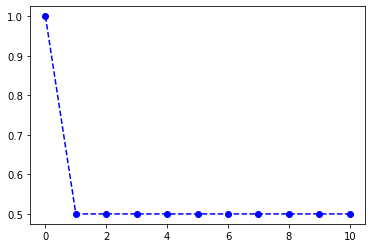

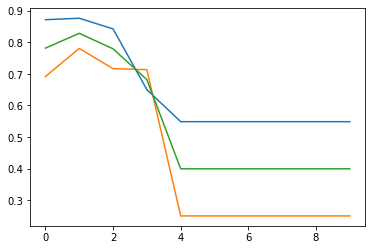

In [3]:
plt.plot(range(len(f1)), f1, "--bo", label = "f1 score")
plt.show()
plt.plot(range(len(acc_s)), acc_s)
plt.plot(range(len(acc_e)), acc_e)
plt.plot(range(len(sun)), sun)
plt.show()